# Feature analysis
## 1. Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
import sys
from sklearn.model_selection import KFold, cross_val_score, train_test_split, StratifiedKFold
from sklearn import metrics
from sklearn import preprocessing
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from mrmr import mrmr_classif
import matplotlib.pyplot as plt
from pprint import pprint
#import tensorflow as tf
#from autokeras import StructuredDataClassifier
import xgboost as xgb
import shap
import gc
import json
from itertools import islice
import functools
from datetime import date
#%matplotlib inline
#import mpld3
#mpld3.enable_notebook()
# rf, pps (https://github.com/8080labs/ppscore), correleation, shapele, mrmr


## 2. Prepare data

In [2]:
def get_data(normalised=1, weighted=True, title_prepend=True, time_split=0, topics_separate=False):
    if time_split %2 !=0:
         raise Exception("time_split has to be divisble by 2")
    
    
    df = pd.read_csv("/mnt/g/My Drive/Msc/Thesis/Coding/dataset_output/prepend_scores_no_utc.csv", nrows=3)
    cols_to_read = list(df.columns).remove("post_text")
    df = pd.read_csv("/mnt/g/My Drive/Msc/Thesis/Coding/dataset_output/prepend_scores_no_utc.csv", nrows=400000, usecols=cols_to_read)
    
    
    if normalised < 2:
        df = df[df.columns.drop(list(df.filter(regex="_abs" if normalised == 1 else "_norm")))]
        

    keys = ["info", "yta", "nah", "esh", "nta"]
    weight = "weighted_" if weighted else ""
    values = ["reactions_"+weight+k.upper() for k in keys]
    acros = dict(zip(keys, values))
    
    dfs = []
    if time_split > 0:
        print("Data split by date range")
        for i in range(len(spacing)-1):
            start = spacing[i]
            end = spacing[i+1]
            dfs.append(df.loc[start <= df["post_created_utc"] & df["post_created_utc"]<end])
    elif topics_separate >0:
        
        topic_min = df["topic_nr"].min()
        topic_max = df["topic_nr"].max()
        print(f"Data split by topic ({topic_min}, {topic_max})")
         
        for i in range(topic_min, topic_max+1):
            dfs.append(df.loc[df["topic_nr"]==i])
    else:
        dfs = [df]

    print(f"Number of dataframes: {len(dfs)}")

    return dfs, acros


## 3. Data sampling

In [3]:
def sampling(y, kind="up", indices=[], verbose=False):
    
    df_y = pd.DataFrame(data={"Y":y})
    
    if len(indices)>0:
        if verbose:
            print(f"Using {len(indices)} indices")
    else:
        indices = range(len(indices))
        

    # Get list of indices for classes that are in the indices array
    c0_idx = pd.Series(df_y.loc[df_y["Y"]==0].index.values)
    c0_idx = c0_idx[c0_idx.isin(indices)]
    c1_idx = pd.Series(df_y.loc[df_y["Y"]==1].index.values)
    c1_idx = c1_idx[c1_idx.isin(indices)]
    
    if verbose:
        print(f"    Y=0: {c0_idx.shape}")
        print(f"    Y=1: {c1_idx.shape}")

    if kind == "up":
        #upsample
        if len(c0_idx)>len(c1_idx):
            n = len(c0_idx)
            c1_idx_sampeled = c1_idx.sample(n=n, random_state = 1, replace=len(c1_idx)<n).values
            c0_idx_sampeled = c0_idx.values
            if verbose:
                print(f"Upsampling Y=1 with {n} samples")
                
        elif len(c0_idx)<len(c1_idx):
            n = len(c1_idx)
            c0_idx_sampeled = c0_idx.sample(n=n, random_state = 1, replace=len(c0_idx)<n).values
            c1_idx_sampeled = c1_idx.values
            if verbose:
                print(f"Upsampling Y=0 with {n} samples")
                
    elif kind =="down":
        #downsample
        if len(c0_idx)>len(c1_idx):
            n = len(c1_idx)
            c0_idx_sampeled = c0_idx.sample(n=n, random_state = 1, replace=len(c0_idx)<n).values
            c1_idx_sampeled = c1_idx.values
            if verbose:
                print(f"Downsampling Y=0 with {n} samples")
        elif len(c0_idx)<len(c1_idx):
            n = len(c0_idx)
            c1_idx_sampeled = c1_idx.sample(n=n, random_state = 1, replace=len(c1_idx)<n).values
            c0_idx_sampeled = c0_idx.values
            if verbose:
                print(f"Downsampling Y=1 with {n} samples")

    all_idx = np.concatenate((c0_idx_sampeled, c1_idx_sampeled), axis=0)
    
    if verbose:
        df_tmp = df_y.iloc[all_idx]
        print(f"   Y=0: {len(df_tmp.loc[df_tmp['Y']==0])}")
        print(f"   Y=1: {len(df_tmp.loc[df_tmp['Y']==1])}")
    return all_idx

### 3.5 Memory usage & helpers

In [4]:
def obj_size_fmt(num):
    if num<10**3:
        return "{:.2f}{}".format(num,"B")
    elif ((num>=10**3)&(num<10**6)):
        return "{:.2f}{}".format(num/(1.024*10**3),"KB")
    elif ((num>=10**6)&(num<10**9)):
        return "{:.2f}{}".format(num/(1.024*10**6),"MB")
    else:
        return "{:.2f}{}".format(num/(1.024*10**9),"GB")


def memory_usage():
    memory_usage_by_variable=pd.DataFrame({k:sys.getsizeof(v)\
    for (k,v) in globals().items()},index=['Size'])
    memory_usage_by_variable=memory_usage_by_variable.T
    memory_usage_by_variable=memory_usage_by_variable.sort_values(by='Size',ascending=False).head(10)
    memory_usage_by_variable['Size']=memory_usage_by_variable['Size'].apply(lambda x: obj_size_fmt(x))
    return memory_usage_by_variable

def opposite_jdgmt(judgement):
    if judgement == "nta":
        return "yta"
    elif judgement == "nah":
        return "esh"
    elif judgement == "yta":
        return "nta"
    elif judgement =="esh":
        return "nah"
    else:
        return judgement
    
# mapping is either "clip", meaning negative votes are just set to 0, or "oppossite", meaning we use the mapping table in "opposite_jdgmt"
def map_negative_values(df, mapping="clip"):
    # Seems buggy
    if mapping == "opposite":
        for k in acros.keys():
            if k == "info":
                continue
            acr = acros[k]
            # create temporary columns containing zeros and only negative votes for each vote type (except info)
            df[acr+"_neg_vals"] = df[acr]
            
            df.loc[df[acr+"_neg_vals"] > 0] = 0
            df.loc[df[acr+"_neg_vals"] < 0] = df.loc[df[acr+"_neg_vals"] < 0]*-1

        for k in acros.keys():
            if k == "info":
                continue
            acr = acros[k]
            #set negative values to 0 & add opposite judgement votes
            
            df[acr][df[acr] < 0] = 0
            df[acr] = df[acr] + df[opposite_jdgmt(acr)]
        
    elif mapping =="clip":
        for k in acros.keys():
            acr = acros[k]
            df[acr][df[acr] < 0] = 0
            
    # finally set all negative info votes to 0
    df[df[acros["info"]] < 0] = 0
    
    print("info sum", df[acros["info"]].min())
    
    return df



## 4. Data prediction Classes or Regression values

In [5]:
def get_data_classes(df, acros, ratio=0.5, verbose=False, predict="class", judgement_weighted=True, mapping="clip"):
    if verbose:
        print(f"df original shape {df.shape}")
        
    n_rows_old = len(df)
    
    # Map negative judgements to opposing judgement
    # i.e. YTA<->NTA, ESH<->NAH
    if judgement_weighted:
        df = map_negative_values(df, mapping=mapping)
    
    if predict=="class":   
        # We only look at YTA and NTA
        df["YTA_ratio"] = df[acros["yta"]]/(df[acros["info"]]+ df[acros["yta"]]+ df[acros["nah"]]+df[acros["esh"]]+df[acros["nta"]])

        # drop all rows where the majority is not YTA or NTA
        df = df.loc[((df[acros["yta"]] > df[acros["info"]]) & (df[acros["yta"]] > df[acros["nah"]]) & (df[acros["yta"]] > df[acros["esh"]])) | ((df[acros["nta"]] > df[acros["info"]]) & (df[acros["nta"]] > df[acros["nah"]]) & (df["reactions_weighted_NTA"] > df[acros["esh"]]))]
        if verbose:
            print(f"Drop all rows where majority is not YTA or NTA {df.shape}")

        #drop all rows that are not "extreme" enough
        df = df.loc[(1-ratio<=df["YTA_ratio"]) | (df["YTA_ratio"]<=ratio)]
        if verbose:
            print(f"Removed {n_rows_old-len(df)} rows b.c. not enough agreement. Now {df.shape}")

        #specifc classes & drop unnecesarry
        df["Y"] = np.where(df[acros["yta"]] > df[acros["nta"]], 1,  0) # YTA = Class 1, NTA = class 0
        if verbose:
            print(df.shape)
            
    elif predict == "ratio":
        # Y = asshole ratio(AHR) = (YTA+ESH)/(YTA+ESH+NTA+NAH)
        df["Y"] = (df[acros["yta"]]+df[acros["esh"]])/(df[acros["yta"]]+ df[acros["nah"]]+df[acros["esh"]]+df[acros["nta"]])
        
        #drop NAs & infty
        df = df.replace([np.inf, -np.inf], np.nan)
        df = df.dropna()
        if verbose:
           print(f"Removed {n_rows_old-len(df)} rows b.c. no votes. Now {df.shape}")
        n_rows_old = len(df)
        df = df.loc[(1-ratio<=df["Y"]) | (df["Y"]<=ratio)]
        if verbose:
            print(f"Removed {n_rows_old-len(df)} rows b.c. not enough agreement. Now {df.shape}")
        
        
        
        
     # get list of all columns that contain uppercase vote acronym
    vote_acroynms = list(filter(lambda x: any([acr.upper() in x for acr in list(acros.keys())]), list(df.columns)))    
    df = df.drop(columns=vote_acroynms+["post_text", "post_id", "post_created_utc", "Unnamed: 0"])

    # Removing top 4 most important features leads to 0.66 f1
    #df = df.drop(columns=["speaker_account_comment_karma", "post_num_comments", "speaker_account_link_karma", "speaker_account_age"])
    if verbose:
        print(df.shape)
    
    X = df.drop(columns=["Y"])
    y = df["Y"].to_numpy()

    feat_name_lst = list(X.columns)

    # scaling
    scaler = preprocessing.StandardScaler().fit(X)
    X_scaled = scaler.transform(X)
    return X_scaled, y, feat_name_lst    

# 5. Where the magic happens

REGRESSION
----
SIMPLIFYING
Models:
  xgboost

Classification params:
{
    "norm_vals": [
        0
    ],
    "weighted_vals": [
        true
    ],
    "title_prep_vals": [
        true
    ],
    "sampling_vals": [
        "up"
    ],
    "topics_separate": false,
    "predict": "ratio",
    "mapping_type": [
        "clip",
        "opposite"
    ],
    "ratio": [
        0.5
    ]
}
Number of dataframes: 1
nr samples 618203
df original shape (618203, 190)
info sum 0
Removed 493602 rows b.c. no votes. Now (124601, 191)
Removed 0 rows b.c. not enough agreement. Now (124601, 191)
(124601, 176)
Running (1/2):
  xgboost_norm=0_title=prep_weighted_ratio=0.5_clip


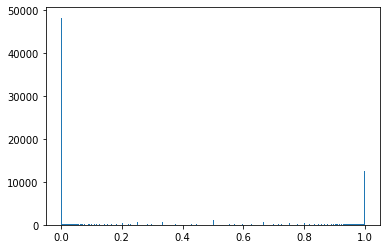

df original shape (618203, 191)
info sum 0
Removed 618203 rows b.c. no votes. Now (0, 195)
Removed 0 rows b.c. not enough agreement. Now (0, 195)
(0, 176)


ValueError: Found array with 0 sample(s) (shape=(0, 175)) while a minimum of 1 is required by StandardScaler.

In [11]:
FORCE_SIMPLIFY = True
SHOW_SHAPLY = True
SHOW_PREDICTION_DISTRIBUTION = True
FEAT_IMPORTANCE_N = 50

params = {
    "norm_vals": [0,1,2],               # normalised: 0 = only "abs", 1 = only "norm", 2 = norm and abs
    "weighted_vals" : [True, False],     # weighted_vals: whether votes should be weighted by comment score FALSE IS BETTER 0.32
    "title_prep_vals" : [True],   # title_prepend: whether to use the title prepended or standalone dataset
    "sampling_vals" : ["up", "down"],   # sampling_vals: which type of sampling should be done
    "topics_separate": False,           # if each topic should be analysed separately
    "predict":"ratio",                  # should we predict "class" (classification for binary) or "ratio" (regression for AHR)
    "mapping_type":["clip", "opposite"], # should we "clip" negative votes or map them to the "opposite"
    "ratio": [0.5, 0.4,0.3, 0.2, 0.1, 0.05 ]      # which most extreme AHR or YTA_ratio we want to predict
}


print("CLASSIFICATION\n----" if params["predict"]=="class" else "REGRESSION\n----")
if FORCE_SIMPLIFY:
    print("SIMPLIFYING")
    for k, v in params.items():
        if isinstance(v, list):
            params[k] = [v[0]]

if params["predict"] == "ratio":
    params["sampling_vals"] = ["up"]

params["mapping_type"] = ["clip", "opposite"]

# mpc = MLPClassifier( random_state=1) seems pretty shitty
# boost = GradientBoostingClassifier(n_estimators=300, learning_rate=1.0,max_depth=20, random_state=0)
xgboost = xgb.XGBClassifier(verbosity = 0) if params["predict"] == "class" else xgb.XGBRegressor(verbosity = 0)
rfc = RandomForestClassifier(n_estimators= 766, min_samples_split= 2, min_samples_leaf= 1, max_features="auto", max_depth= 40, bootstrap= False, n_jobs=-1) if params["predict"] == "class" else RandomForestRegressor(n_estimators= 766, min_samples_split= 2, min_samples_leaf= 1, max_features="auto", max_depth= 40, bootstrap= False, n_jobs=-1)

#classifiers = [(boost,"boost"), (xgboost,"xgboost"), (rfc,"rfc")]
classifiers = [(xgboost, "xgboost"),]


print("Models:\n"+"\n".join(["  "+str(s) for m,s in classifiers]))
print("\nClassification params:\n"+str(json.dumps(params, indent = 4)))

#cv = KFold(n_splits=SPLITS, random_state=1, shuffle=True)
#for train, test in cv.split(X, y):
test_scores = {}
nr_samples = []
class_ratio = [] #only used for classification
top_n_features = {}

current_iter = 1
max_iter = functools.reduce(lambda a, b: a*b, [len(x) if isinstance(x, list) else 1 for x in list(params.values())])
for norm in params["norm_vals"]:
    for weighted in params["weighted_vals"]:
        for title_prep in params["title_prep_vals"]:
        
            #TODO: shap dependency plot  
            if "dfs" in locals() or "dfs" in globals():
                for i in dfs:
                    del i
            if "df" in list(memory_usage().index):
                del df
                gc.collect()
            
                
            dfs, acros = get_data(normalised=norm, weighted=weighted, title_prepend=title_prep, topics_separate=params["topics_separate"])

            print("nr samples",len(dfs[0]))
            for smp in params["sampling_vals"]:
                for rto in params["ratio"]:
                    for mpt in params["mapping_type"]:
                        for df in dfs: 
                            X, y, feat_name_lst = get_data_classes(df, ratio=rto, acros=acros, predict=params["predict"],judgement_weighted=weighted, mapping=mpt, verbose=True)    
                            train, test = train_test_split(range(len(X)), test_size=0.33, random_state=42)

                            if params["predict"]=="class":
                                print("Doing sampling")
                                train = sampling(y, kind=smp, indices=train, verbose=False)

                            for clf_tpl in classifiers:
                                clf = clf_tpl[0]
                                clf_name = clf_tpl[1]
                                clf_name += f"_norm={norm}"
                                clf_name += "_title=" + "prep" if title_prep else "stdal"
                                clf_name += "_weighted" if weighted else ""
                                clf_name += "_ratio="+str(rto)
                                if params["predict"] == "ratio":
                                    clf_name += "_"+mpt

                                clf_name += "_topic_"+str(df["topic_nr"].iloc[0]) if params["topics_separate"] else ""                      

                                print(f"Running ({current_iter}/{max_iter*len(dfs)}):\n  {clf_name}")

                                X_train = X[train, :]
                                y_train = y[train]
                                X_test = X[test, :]
                                y_test = y[test]

                                if SHOW_PREDICTION_DISTRIBUTION:
                                    plt.hist(y[train], bins=10*32)
                                    plt.show()

                                clf.fit(X_train, y_train)
                                y_pred = clf.predict(X_test)
                                
                                if SHOW_SHAPLY:
                                    #explainer = shap.explainers.GPUTree(clf, X_train)
                                    explainer = shap.explainers.Tree(clf, X_train)
                                    shap_values = explainer(X_train)
                                    shap.summary_plot(shap_values, X_train, feature_names=feat_name_lst, max_display=50)
                                    
                                    # save top N features
                                    shapely_abs = np.absolute(shap_values)
                                    id_sorted = np.argsort(shapely_abs[i])#? why [i]
                                    top_n_features[clf_name] = feat_name_lst[id_sorted[:FEAT_IMPORTANCE_N]]
                                    top_n_features[clf_name+" (SHAP SCORES)"] = shapely_abs[:FEAT_IMPORTANCE_N]
                                    


                                # We have more Y=0 (NTA) than Y=1 (YTA)
                                #metrics.plot_confusion_matrix(classify, X_test, y_test)  
                                #plt.show()
                                #print(metrics.classification_report(y_test, y_pred, target_names=["NTA (0)", "YTA (1)"]))

                                if params["predict"] == "class":
                                    # testing score
                                    f1_test = metrics.f1_score(y_test, y_pred, average="weighted")
                                    acc_test = metrics.accuracy_score(y_test, y_pred)
                                    test_scores[clf_name]=f1_test
                                    nr_samples.append(len(X_train))
                                    ratio = y[train].sum()/len(y[train])
                                    if ratio < 0.5:
                                        ratio = (len(y[train])-y[train].sum())/len(y[train])
                                    class_ratio.append(ratio)
                                    current_iter+=1
                                    print(f"    Accuracy: {acc_test}\n    F1: {f1_test}")

                                elif params["predict"] == "ratio":
                                    mean_abs = metrics.mean_absolute_error(y_test, y_pred)
                                    mean_sqr = metrics.mean_squared_error(y_test, y_pred)
                                    rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)
                                    test_scores[clf_name]=rmse
                                    nr_samples.append(len(X_train))
                                    current_iter+=1
                                    print(f"    Mean absolute: {mean_abs}\n    Mean squared: {mean_sqr}\n    Root Mean Squared: {rmse}")
 
                       
#test_scores = np.array(test_scores)
#print(f"Average Test F1: {np.mean(test_scores[:,0])}, Test Accuracy: {np.mean(test_scores[:,1])}")

classifiers = list(test_scores.keys())
scores = list(test_scores.values())
df_plt = pd.DataFrame({'scores': scores,
                       'samples': nr_samples, 
                        "class_ratio":class_ratio if len(class_ratio) > 0 else np.zeros(len(scores))})

fig, ax1 = plt.subplots(figsize=(15, 10))

df_plt['samples'].plot(kind='line', marker='d', secondary_y=True, ylabel="# Samples").set_ylabel("# Samples")
df_plt['scores'].plot(kind='bar', color='r', ylabel="F1 score" if params["predict"]=="class" else "RMSE").set_xticklabels(classifiers) 
if len(class_ratio)>0:
    df_plt['class_ratio'].plot(kind='bar', color='orange')
plt.xlabel("Classifiers")
ax1.legend(["Classification", "Class Ratios"])

plt.title("Comparing "+("F1 " if params["predict"]=="class" else "RMSE ")+"of different classifiers")
plt.show()
#print(test_scores)

print(f'Average : {"f1 " if params["predict"]=="class" else "RMSE "}{np.mean(scores)}')

test_scores_lst = list(test_scores.items())

srted = sorted(test_scores_lst, key=lambda tup: tup[1])
#srted = test_scores_lst.sort(key=lambda x:x[1])
print("Sorted:")
for c,s in srted:
    print("   ", c, '->', s)
    

# For each feature generate a list of all indices where it appears over various classifiers    
print("Most important features:")
top_feat_val = filter(lambda x: isinstance(x[0], str), list(top_n_features.values()))
overal_top_feat = {}
for i in range(len(top_feat_val)):
    current_top_feats = top_feat_val[i]
    for j in range(len(current_top_feats)):
        if top_feat_val[i] in overal_top_feat:
            overal_top_feat[i] = top_feat_val[i] + [current_top_feats.index(top_feat_val[i])]
        else:
            overal_top_feat[i] = [current_top_feats.index(top_feat_val[i])]

# get overal ranking sum (the one with the smallest ranke is the most important)
for i in range(len(overal_top_feat)):
    overal_top_feat[i] = sum(overal_top_feat[i])
overal_top_feat = dict(sorted(overal_top_feat.items(), key=lambda item: item[1]))

top_n_features["Overal most important"] = list(top_feat_val.keys())
top_n_features["Overal most important (SUM)"] = list(top_feat_val.values())

today = date.today()
output = today.strftime("%d_%m_%Y")
top_n_features_pd = pd.DataFrame.from_dict(top_n_features)
top_n_features.to_excel(output+".xlsx")


# 5.1 Dependency plot

In [ ]:
shap.dependence_plot("rank(2)", shap_values, X_train)

In [ ]:
# we can use shap.approximate_interactions to guess which features
# may interact with age
feature_to_inspect = "topic_nr"
idx = feat_name_lst.index(feature_to_inspect)
inds = shap.approximate_interactions("rank(2)", shap_values, X_train)

# make plots colored by each of the top three possible interacting features
for i in range(3):
    shap.dependence_plot("rank(2)", shap_values, X_train, interaction_index=inds[i])


---

## MRMR

In [16]:
selected_features = mrmr_classif(X_train, y, K = 50)
np_feat_name_lst = np.array(feat_name_lst)
pprint(np_feat_name_lst[selected_features])

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:20<00:00,  2.49it/s]

array(['post_ratio', 'liwc_i', 'liwc_health', 'reactions_is_devil',
       'liwc_time', 'liwc_WC', 'speaker_account_age', 'liwc_home',
       'writing_sty_profanity_norm', 'foundations_WC', 'liwc_posemo',
       'liwc_see', 'liwc_male', 'writing_sty_aita_lst_location',
       'writing_sty_is_wibta', 'liwc_sexual', 'liwc_family',
       'liwc_negate', 'speaker_author_gender', 'liwc_informal',
       'foundations_QMark', 'writing_sty_focus_i_poss_norm', 'liwc_Dic',
       'reactions_is_angel', 'writing_sty_self_prof', 'liwc_QMark',
       'foundations_05                    IngroupVirtue',
       'writing_sty_disgust_norm', 'liwc_relativ',
       'writing_sty_other_prof', 'speaker_account_comment_karma',
       'writing_sty_aita_avg_location', 'liwc_anx', 'liwc_body',
       'liwc_function', 'liwc_netspeak', 'liwc_Authentic', 'liwc_swear',
       'liwc_percept', 'liwc_insight', 'liwc_filler',
       'writing_sty_focus_i_obj_norm', 'liwc_prep',
       'writing_sty_aita_count', 'liwc_focusp

## Random Forest Randomized Search

In [8]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 300, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators':n_estimators,
               'max_features':max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

#random_grid = {'n_estimators':[1000],
#               'max_features':["auto"],
#               'max_depth': [110],
#               'min_samples_split': [10],
#               'min_samples_leaf': [4],
#               'bootstrap': [True]}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 2, verbose=10, random_state=42, n_jobs = 1)
# Fit the random search model

train, test = train_test_split(range(len(X)), test_size=0.2, random_state=42)
train_sampeled = sampling(y, kind="up", indices=train, verbose=False)                  
X_train = X[train_sampeled, :]
y_train = y[train_sampeled]
X_test = X[test, :]
y_test = y[test]
                   
rf_random.fit(X_train, y_train)
print(rf_random.best_params_)

y_pred  = rf_random.predict(X_test)
f1_test = metrics.f1_score(y_test, y_pred)
acc_test = metrics.accuracy_score(y_test, y_pred)
print(f"F1: {f1_test}, accuracy: {acc_test}")
# ca 0.85 acc for 300 esimators, rest default

Fitting 2 folds for each of 50 candidates, totalling 100 fits
[CV 1/2; 1/50] START bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=377
[CV 1/2; 1/50] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=377;, score=0.619 total time= 2.2min
[CV 2/2; 1/50] START bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=377
[CV 2/2; 1/50] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=377;, score=0.579 total time= 2.4min
[CV 1/2; 2/50] START bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000
[CV 1/2; 2/50] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000;, score=0.516 total time= 3.6min
[CV 2/2; 2/50] START bootstrap=True, max_depth=10, max_features=sqrt, min_s

[CV 1/2; 15/50] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=533;, score=0.629 total time= 4.7min
[CV 2/2; 15/50] START bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=533
[CV 2/2; 15/50] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=533;, score=0.589 total time= 5.0min
[CV 1/2; 16/50] START bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=922
[CV 1/2; 16/50] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=922;, score=0.628 total time= 7.8min
[CV 2/2; 16/50] START bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=922
[CV 2/2; 16/50] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=

[CV 2/2; 29/50] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000;, score=0.584 total time= 9.1min
[CV 1/2; 30/50] START bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=688
[CV 1/2; 30/50] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=688;, score=0.614 total time= 3.8min
[CV 2/2; 30/50] START bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=688
[CV 2/2; 30/50] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=688;, score=0.566 total time= 3.9min
[CV 1/2; 31/50] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=688
[CV 1/2; 31/50] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=68

[CV 1/2; 44/50] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=377;, score=0.604 total time= 2.0min
[CV 2/2; 44/50] START bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=377
[CV 2/2; 44/50] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=377;, score=0.566 total time= 2.2min
[CV 1/2; 45/50] START bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300
[CV 1/2; 45/50] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300;, score=0.634 total time= 2.6min
[CV 2/2; 45/50] START bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300
[CV 2/2; 45/50] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300

## Neural Network (Deprecated)

In [22]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(lr=0.03),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)


cv = KFold(n_splits=SPLITS, random_state=1, shuffle=True)


test_scores = []
for train, test in cv.split(X, y):
    train_sampeled = sampling(y, kind="up", indices=train, verbose=False)
    
    X_train = X[train_sampeled, :]
    y_train = y[train_sampeled]
    X_test = X[test, :]
    y_test = y[test]
    
    history = model.fit(X_train, y_train, epochs=100)
    y_pred = model.predict(X_test)

    # We have more Y=0 (NTA) than Y=1 (YTA)
    metrics.plot_confusion_matrix(rfc, X_test, y_test)  
    plt.show()
    print(metrics.classification_report(y_test, y_pred, target_names=["NTA (0)", "YTA (1)"]))
    
    # testing score
    f1_test = metrics.f1_score(y_test, y_pred,average="weighted")
    acc_test = metrics.accuracy_score(y_test, y_pred)
    test_scores.append([f1_test, acc_test])
    
    print(f"F1 {f1_test}, accuracy {acc_test}")
    #print("----------")
    #print(f"nr classes {list(set(y_test))}")
    # training score
    #f1_train = metrics.f1_score(y_train, y_pred_train,)
    #acc_train = metrics.accuracy_score(y_train, y_pred_train,)
    #train_scores.append([f1_train,acc_train])
    #Visualise training
    rcParams['figure.figsize'] = (18, 8)
    rcParams['axes.spines.top'] = False
    rcParams['axes.spines.right'] = False
    plt.plot(
        np.arange(1, 101), 
        history.history['loss'], label='Loss'
    )
    plt.plot(
        np.arange(1, 101), 
        history.history['accuracy'], label='Accuracy'
    )
    plt.plot(
        np.arange(1, 101), 
        history.history['precision'], label='Precision'
    )
    plt.plot(
        np.arange(1, 101), 
        history.history['recall'], label='Recall'
    )
    plt.title('Evaluation metrics', size=20)
    plt.xlabel('Epoch', size=14)
    plt.legend();
    
    
test_scores = np.array(test_scores)
print(f"Average Test F1: {np.mean(test_scores[:,0])}, Test Accuracy: {np.mean(test_scores[:,1])}")
    
    



2021-12-13 10:50:25.081837: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-12-13 10:50:25.084136: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-12-13 10:50:25.084164: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 computeCapability: 7.5
coreClock: 1.725GHz coreCount: 46 deviceMemorySize: 8.00GiB deviceMemoryBandwidth: 417.23GiB/s
2021-12-13 10:50:25.084185: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-12-13 10:50:25.107041: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-12-13 10:50:25.107104: I tensorflow/stream_executo

Epoch 1/100
2164/2164 [==============================] - 4s 1ms/step - loss: 0.7090 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.4902
Epoch 2/100
2164/2164 [==============================] - 3s 1ms/step - loss: 0.6938 - accuracy: 0.5030 - precision: 0.5028 - recall: 0.5316
Epoch 3/100
2164/2164 [==============================] - 3s 1ms/step - loss: 0.6938 - accuracy: 0.5026 - precision: 0.5026 - recall: 0.4971
Epoch 4/100
2164/2164 [==============================] - 3s 1ms/step - loss: 0.6939 - accuracy: 0.4988 - precision: 0.4988 - recall: 0.4956
Epoch 5/100
2164/2164 [==============================] - 3s 1ms/step - loss: 0.6939 - accuracy: 0.4974 - precision: 0.4973 - recall: 0.4794
Epoch 6/100
2164/2164 [==============================] - 3s 1ms/step - loss: 0.6937 - accuracy: 0.5022 - precision: 0.5021 - recall: 0.5308
Epoch 7/100
2164/2164 [==============================] - 3s 1ms/step - loss: 0.6938 - accuracy: 0.5011 - precision: 0.5011 - recall: 0.5339
Epoch 8/100
2164/216

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

## Random forest feature importance (DEPRECATED)

In [23]:
plt.rcParams["figure.figsize"] = (13,6)
n_features_to_show = 30
def feat_importance(forest, n_to_show):
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    importances_index_desc = np.argsort(forest.feature_importances_)[::-1]

    importance_sorted = forest.feature_importances_[importances_index_desc]
    labels_sorted = [feat_name_lst[i] for i in importances_index_desc]
    #std_sorted = [std[i] for i in importances_index_desc]

    forest_importances = pd.Series(importance_sorted[:n_to_show], index=labels_sorted[:n_to_show])
    fig, ax = plt.subplots()
    forest_importances.plot.bar(ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    print("Plot done")
    
def feat_importance_fix_cardinality(forest, X_test, y_test, n_to_show):
    result = permutation_importance(forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    importances_index_desc = np.argsort(result.importances_mean)[::-1]
    importance_sorted = result.importances_mean[importances_index_desc]
    labels_sorted = [feat_name_lst[i] for i in importances_index_desc]
    std_sorted = result.importances_std[importances_index_desc]

    forest_importances = pd.Series(importance_sorted, index=labels_sorted)[:n_to_show]
    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std_sorted[:n_to_show], ax=ax)
    #forest_importances.plot.bar(ax=ax)
    ax.set_title("Feature importances using permutation on full model")
    ax.set_ylabel("Mean accuracy decrease")
    fig.tight_layout()
    plt.show()
    print("Cardinality done")

In [24]:
feat_importance(rfc, 50)
#feat_importance_fix_cardinality(rfc, X_test, y_test, 50)

AttributeError: 'RandomForestClassifier' object has no attribute 'estimators_'

## Print topic id & topic string

In [14]:
import pandas as pd
df_topics = pd.read_csv("/mnt/g/My Drive/Msc/Thesis/Coding/dataset_output/helpers/topic_nr_to_str_24_11_2021.csv")
df_topics

,topic_nr,topic_str
0,-1,im_dont_didnt_mom
1,0,friend_friends_im_relationship
2,1,roommate_room_apartment_roommates
3,2,dad_mom_mother_parents
4,3,work_job_boss_manager
5,4,birthday_christmas_party_family
6,5,dog_cat_dogs_cats
7,6,sister_shes_parents_mom
8,7,wife_husband_home_dont
9,8,wedding_married_family_ring


# Trying things out

In [1]:
import pandas as pd
df = pd.read_csv("/mnt/g/My Drive/Msc/Thesis/Coding/dataset_output/prepend_utc.csv")


/home/philipp/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (116,117) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
print(df.memory_usage(deep=True).to_string())

Index                                                       128
post_id                                                38946789
post_text                                            1581032551
post_num_comments                                       4945624
writing_sty_past_abs                                    4945624
writing_sty_present_abs                                 4945624
writing_sty_future_abs                                  4945624
writing_sty_past_norm                                   4945624
writing_sty_present_norm                                4945624
writing_sty_future_norm                                 4945624
writing_sty_active_abs                                  4945624
writing_sty_passive_abs                                 4945624
writing_sty_active_norm                                 4945624
writing_sty_passive_norm                                4945624
writing_sty_sent_polarity                               4945624
writing_sty_sent_subjectivity           

In [ ]:
df.dtypes.to_string()

In [11]:
df.replace({False: 0, True: 1}, inplace=True)
df = df["reactions_is_angel"].astype(int)

ValueError: invalid literal for int() with base 10: 'False'

In [ ]:
df["reactions_is_angel"].to_string()

In [15]:
a = df['reactions_is_devil'].unique()
print(a)

[0 1]


In [14]:
df['reactions_is_devil'] = df['reactions_is_devil'].replace("False", 0)

In [16]:
df.to_csv("/mnt/g/My Drive/Msc/Thesis/Coding/dataset_output/prepend_utc.csv")

In [15]:
def obj_size_fmt(num):
    if num<10**3:
        return "{:.2f}{}".format(num,"B")
    elif ((num>=10**3)&(num<10**6)):
        return "{:.2f}{}".format(num/(1.024*10**3),"KB")
    elif ((num>=10**6)&(num<10**9)):
        return "{:.2f}{}".format(num/(1.024*10**6),"MB")
    else:
        return "{:.2f}{}".format(num/(1.024*10**9),"GB")


def memory_usage():
    memory_usage_by_variable=pd.DataFrame({k:sys.getsizeof(v)\
    for (k,v) in globals().items()},index=['Size'])
    memory_usage_by_variable=memory_usage_by_variable.T
    memory_usage_by_variable=memory_usage_by_variable.sort_values(by='Size',ascending=False).head(10)
    memory_usage_by_variable['Size']=memory_usage_by_variable['Size'].apply(lambda x: obj_size_fmt(x))
    return memory_usage_by_variable

memory_usage()

,Size
df,2.59GB
X_train,141.91MB
X_test,48.83MB
y_train,724.11KB
train_sampeled,724.11KB
train,565.36KB
test,278.69KB
y_pred,249.23KB
y_test,249.23KB
_i5,5.92KB


In [8]:
#finally check memory usage
memory_usage()

,Size
df,2.49GB
X_train,114.53MB
X_test,56.41MB
train,715.63KB
y_train,654.52KB
test,352.81KB
y_test,322.43KB
_i6,8.28KB
_ii,8.28KB
_i5,3.08KB


In [9]:
del df
del X_train
del X_test
del y_train
del y_test
#triggering collection
gc.collect()

#finally check memory usage
memory_usage()

,Size
train,715.63KB
test,352.81KB
_i6,8.28KB
_iii,8.28KB
_i5,3.08KB
_i4,2.28KB
_i3,2.17KB
_i2,1.47KB
RandomForestRegressor,1.44KB
feat_name_lst,1.42KB


In [8]:
df_std = pd.read_csv("/mnt/g/My Drive/Msc/Thesis/Coding/dataset_output/standalone.csv", nrows=3)
#cols_to_read = list(df_std.columns).remove("post_text")
liwc_cols = ["liwc_post_id", "liwc_title_post_id"]
mf_cols = ["foundation_post_id", "foundations_title_post_id"]
#cols_to_read = list(filter(lambda x: (not x == "post_text") and (not x in liwc_cols) and (not x in mf_cols) , list(df_std.columns)))
cols_to_read = list(filter(lambda x: "foundation" in x.lower() or x.lower() == "post_id" , list(df_std.columns)))
print(cols_to_read)
df_std = pd.read_csv("/mnt/g/My Drive/Msc/Thesis/Coding/dataset_output/standalone.csv", usecols=cols_to_read)

#print(list(df_std.columns))
#memory_usage()
print(df_std.shape)


['post_id', 'foundations_post_id', 'foundations_WC', 'foundations_WPS', 'foundations_Sixltr', 'foundations_Dic', 'foundations_01 HarmVirtue', 'foundations_02 HarmVice', 'foundations_03 FairnessVirtue', 'foundations_04 FairnessVice', 'foundations_05 IngroupVirtue', 'foundations_06 IngroupVice', 'foundations_07 AuthorityVirtue', 'foundations_08 AuthorityVice', 'foundations_09 PurityVirtue', 'foundations_10 PurityVice', 'foundations_11 MoralityGeneral', 'foundations_AllPunc', 'foundations_Period', 'foundations_Comma', 'foundations_Colon', 'foundations_SemiC', 'foundations_QMark', 'foundations_Exclam', 'foundations_Dash', 'foundations_Quote', 'foundations_Apostro', 'foundations_Parenth', 'foundations_OtherP', 'foundations_title_post_id', 'foundations_title_WC', 'foundations_title_WPS', 'foundations_title_Sixltr', 'foundations_title_Dic', 'foundations_title_01 HarmVirtue', 'foundations_title_02 HarmVice', 'foundations_title_03 FairnessVirtue', 'foundations_title_04 FairnessVice', 'foundatio

In [9]:
print(list(df_std.columns))
df_std.to_csv("/mnt/g/My Drive/Msc/Thesis/Coding/dataset_output/standalone/foundations.csv")

['post_id', 'foundations_post_id', 'foundations_WC', 'foundations_WPS', 'foundations_Sixltr', 'foundations_Dic', 'foundations_01 HarmVirtue', 'foundations_02 HarmVice', 'foundations_03 FairnessVirtue', 'foundations_04 FairnessVice', 'foundations_05 IngroupVirtue', 'foundations_06 IngroupVice', 'foundations_07 AuthorityVirtue', 'foundations_08 AuthorityVice', 'foundations_09 PurityVirtue', 'foundations_10 PurityVice', 'foundations_11 MoralityGeneral', 'foundations_AllPunc', 'foundations_Period', 'foundations_Comma', 'foundations_Colon', 'foundations_SemiC', 'foundations_QMark', 'foundations_Exclam', 'foundations_Dash', 'foundations_Quote', 'foundations_Apostro', 'foundations_Parenth', 'foundations_OtherP', 'foundations_title_post_id', 'foundations_title_WC', 'foundations_title_WPS', 'foundations_title_Sixltr', 'foundations_title_Dic', 'foundations_title_01 HarmVirtue', 'foundations_title_02 HarmVice', 'foundations_title_03 FairnessVirtue', 'foundations_title_04 FairnessVice', 'foundatio

In [8]:
df_prepend = pd.read_csv("/mnt/g/My Drive/Msc/Thesis/Coding/dataset_output/prepend_utc.csv", nrows=3)
liwc_cols = ['liwc_WC', 'liwc_Analytic', 'liwc_Clout', 'liwc_Authentic', 'liwc_Tone', 'liwc_WPS', 'liwc_Sixltr', 'liwc_Dic', 'liwc_function', 'liwc_pronoun', 'liwc_ppron', 'liwc_i', 'liwc_we', 'liwc_you', 'liwc_shehe', 'liwc_they', 'liwc_ipron', 'liwc_article', 'liwc_prep', 'liwc_auxverb', 'liwc_adverb', 'liwc_conj', 'liwc_negate', 'liwc_verb', 'liwc_adj', 'liwc_compare', 'liwc_interrog', 'liwc_number', 'liwc_quant', 'liwc_affect', 'liwc_posemo', 'liwc_negemo', 'liwc_anx', 'liwc_anger', 'liwc_sad', 'liwc_social', 'liwc_family', 'liwc_friend', 'liwc_female', 'liwc_male', 'liwc_cogproc', 'liwc_insight', 'liwc_cause', 'liwc_discrep', 'liwc_tentat', 'liwc_certain', 'liwc_differ', 'liwc_percept', 'liwc_see', 'liwc_hear', 'liwc_feel', 'liwc_bio', 'liwc_body', 'liwc_health', 'liwc_sexual', 'liwc_ingest', 'liwc_drives', 'liwc_affiliation', 'liwc_achieve', 'liwc_power', 'liwc_reward', 'liwc_risk', 'liwc_focuspast', 'liwc_focuspresent', 'liwc_focusfuture', 'liwc_relativ', 'liwc_motion', 'liwc_space', 'liwc_time', 'liwc_work', 'liwc_leisure', 'liwc_home', 'liwc_money', 'liwc_relig', 'liwc_death', 'liwc_informal', 'liwc_swear', 'liwc_netspeak', 'liwc_assent', 'liwc_nonflu', 'liwc_filler', 'liwc_AllPunc', 'liwc_Period', 'liwc_Comma', 'liwc_Colon', 'liwc_SemiC', 'liwc_QMark', 'liwc_Exclam', 'liwc_Dash', 'liwc_Quote', 'liwc_Apostro', 'liwc_Parenth', 'liwc_OtherP']
mf_cols = ['foundations_WC', 'foundations_WPS', 'foundations_Sixltr', 'foundations_Dic', 'foundations_01                    HarmVirtue', 'foundations_02                    HarmVice', 'foundations_03                    FairnessVirtue', 'foundations_04                    FairnessVice', 'foundations_05                    IngroupVirtue', 'foundations_06                    IngroupVice', 'foundations_07                    AuthorityVirtue', 'foundations_08                    AuthorityVice', 'foundations_09                    PurityVirtue', 'foundations_10                    PurityVice', 'foundations_11                    MoralityGeneral', 'foundations_AllPunc', 'foundations_Period', 'foundations_Comma', 'foundations_Colon', 'foundations_SemiC', 'foundations_QMark', 'foundations_Exclam', 'foundations_Dash', 'foundations_Quote', 'foundations_Apostro', 'foundations_Parenth', 'foundations_OtherP']
cols_to_read = list(filter(lambda x: (not x == "post_text") and (not x in liwc_cols) and (not x in mf_cols) , list(df_prepend.columns)))
df_prepend = pd.read_csv("/mnt/g/My Drive/Msc/Thesis/Coding/dataset_output/prepend_utc.csv", usecols=cols_to_read)
print(df_prepend.shape)
memory_usage()

(618203, 123)


,Size
df_std,1.73GB
df_prepend,627.26MB
_iii,2.89KB
_i5,2.89KB
_i8,2.65KB
_i4,2.28KB
_i3,2.17KB
_i2,1.47KB
_7,1.26KB
_,1.26KB


In [ ]:
print(list(df_prepend.columns))
print(list(df_std.columns))

In [9]:
liwc = list(filter(lambda x: "liwc" in x.lower(), df_prepend))
mf = list(filter(lambda x: "foundation" in x.lower(), df_prepend))
print(liwc)
print(mf)
print(df_prepend.shape)


['liwc_WC', 'liwc_Analytic', 'liwc_Clout', 'liwc_Authentic', 'liwc_Tone', 'liwc_WPS', 'liwc_Sixltr', 'liwc_Dic', 'liwc_function', 'liwc_pronoun', 'liwc_ppron', 'liwc_i', 'liwc_we', 'liwc_you', 'liwc_shehe', 'liwc_they', 'liwc_ipron', 'liwc_article', 'liwc_prep', 'liwc_auxverb', 'liwc_adverb', 'liwc_conj', 'liwc_negate', 'liwc_verb', 'liwc_adj', 'liwc_compare', 'liwc_interrog', 'liwc_number', 'liwc_quant', 'liwc_affect', 'liwc_posemo', 'liwc_negemo', 'liwc_anx', 'liwc_anger', 'liwc_sad', 'liwc_social', 'liwc_family', 'liwc_friend', 'liwc_female', 'liwc_male', 'liwc_cogproc', 'liwc_insight', 'liwc_cause', 'liwc_discrep', 'liwc_tentat', 'liwc_certain', 'liwc_differ', 'liwc_percept', 'liwc_see', 'liwc_hear', 'liwc_feel', 'liwc_bio', 'liwc_body', 'liwc_health', 'liwc_sexual', 'liwc_ingest', 'liwc_drives', 'liwc_affiliation', 'liwc_achieve', 'liwc_power', 'liwc_reward', 'liwc_risk', 'liwc_focuspast', 'liwc_focuspresent', 'liwc_focusfuture', 'liwc_relativ', 'liwc_motion', 'liwc_space', 'liwc_

In [13]:
print(df_prepend["writing_sty_past_abs"])
print(df_std["writing_sty_past_abs"])
print(df_std["title_writing_sty_past_abs"])

0         19
1          6
2          2
3         22
4          9
          ..
618198     7
618199     5
618200     7
618201     1
618202     1
Name: writing_sty_past_abs, Length: 618203, dtype: int64
0          5
1         13
2         16
3         10
4          1
          ..
618198     4
618199    17
618200    16
618201     7
618202     3
Name: writing_sty_past_abs, Length: 618203, dtype: int64


KeyError: 'title_writing_sty_past_abs'

In [ ]:
df_std = df_std.merge(df_prepend, left_on="post_id", right_on="post_id", validate="1:1",suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

### Difference opposite & clip

In [6]:
dfs, acros = get_data(normalised=0, weighted=True, title_prepend=0, topics_separate=False)
print(dfs[0].shape)

Number of dataframes: 1
(400000, 192)


In [7]:
df = dfs[0]
X, y, feat_name_lst = get_data_classes(df, ratio=0.5, acros=acros, predict="ratio",judgement_weighted=True, mapping="opposite", verbose=True)    
train, test = train_test_split(range(len(X)), test_size=0.33, random_state=42)
X_train = X[train, :]
y_train = y[train]
X_test = X[test, :]
y_test = y[test]


plt.hist(y[train], bins=10*32)
plt.show()

oppoiste_y = y[train]

df original shape (400000, 192)
info sum 0
Removed 394739 rows b.c. no votes. Now (5261, 197)
Removed 0 rows b.c. not enough agreement. Now (5261, 197)


KeyError: "['post_created_utc'] not found in axis"

df original shape (400000, 191)
info sum 0
Removed 301987 rows b.c. no votes. Now (98013, 191)
Removed 0 rows b.c. not enough agreement. Now (98013, 191)
(98013, 176)


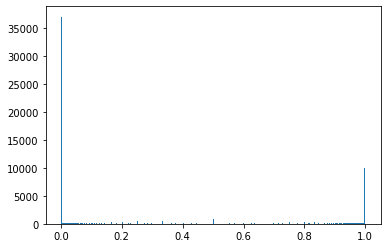

In [ ]:
df = dfs[0]
X, y, feat_name_lst = get_data_classes(df, ratio=0.5, acros=acros, predict="ratio",judgement_weighted=True, mapping="clip", verbose=True)    
train, test = train_test_split(range(len(X)), test_size=0.33, random_state=42)
X_train = X[train, :]
y_train = y[train]
X_test = X[test, :]
y_test = y[test]

clip_y = y["train"]
plt.hist(y[train], bins=10*32)
plt.show()

In [ ]:
np.corrcoef(clip_y, oppoiste_y)